# Metod potpornih vektora

In [1]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import seaborn as sns # Paket za crtanje countplotova

### Učitavanje podataka

In [2]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [4]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [5]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
X,y = load_images(0,60000)

In [7]:
X = np.array(X)
y = np.array(y)

### Podela podataka na train, validacioni i test skup

In [8]:
X_train_and_validation,X_test,y_train_and_validation,y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [9]:
print('Broj slika u skupu za treniranje i validaciju:', len(X_train_and_validation))
print('Broj slika u skupu za testiranje:', len(X_test))

Broj slika u skupu za treniranje i validaciju: 40200
Broj slika u skupu za testiranje: 19800


In [10]:
X_train,X_validation,y_train,y_validation = model_selection.train_test_split(X_train_and_validation, y_train_and_validation, test_size = 0.2, random_state = 42, stratify = y_train_and_validation)

In [11]:
print('Broj slika u skupu za treniranje:', len(X_train))
print('Broj slika u skupu za validaciju:', len(X_validation))

Broj slika u skupu za treniranje: 32160
Broj slika u skupu za validaciju: 8040


### Normalizacija

In [12]:
X_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_train = X_train.reshape(X_train.shape[0], X_shape)
X_validation = X_validation.reshape(X_validation.shape[0],X_shape)
X_test = X_test.reshape(X_test.shape[0],X_shape)

In [13]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [14]:
X_validation = X_validation.astype('float32')
X_validation = X_validation/255

In [15]:
X_test = X_test.astype('float32')
X_test = X_test/255

### Nebalansiranost klasa na train skupu

Broj slika koje nemaju tumor:  23840
Broj slika koje imaju tumor:  8320


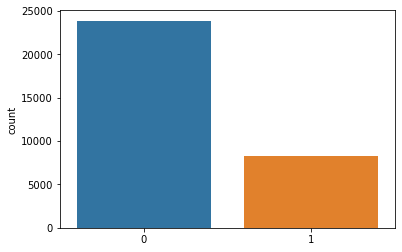

In [16]:
c = np.bincount(y_train)
print('Broj slika koje nemaju tumor: ', c[0])
print('Broj slika koje imaju tumor: ', c[1])
sns.countplot(y_train)
plt.show()

In [17]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state = 0,sampling_strategy = 'auto')
X_train, y_train = rus.fit_sample(X_train, y_train)

In [18]:
print('Broj slika u skupu za treniranje nakon under-samplinga:', len(X_train))

Broj slika u skupu za treniranje nakon under-samplinga: 16640


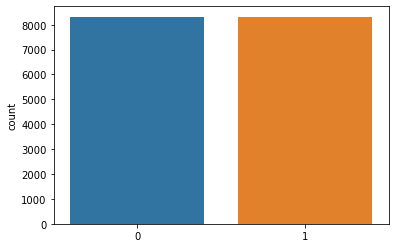

In [19]:
sns.countplot(y_train)
plt.show()

### Redukcija dimenzija pomoću PCA

In [20]:
pca = PCA()
pca.fit(X_train)

PCA()

In [21]:
var = np.cumsum(pca.explained_variance_ratio_)

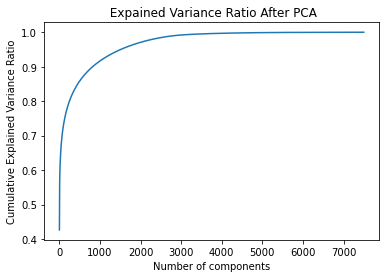

In [22]:
plt.plot(np.arange(X_shape),var)
plt.title(' Expained Variance Ratio After PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [23]:
print('Broj komponenti koji opisuje 80% varijanse: ', np.where(var>=0.8)[0][0])

Broj komponenti koji opisuje 80% varijanse:  246


In [24]:
img_pca = PCA(n_components = 250)
img_pca.fit(X_train,y_train)
X_train = img_pca.transform(X_train)
X_validation = img_pca.transform(X_validation)

### Izbor hiperparametara modela

In [25]:
Cs = [10**i for i in range(-3,3)]
gammas = [10**i for i in range(-3,3)]
best_c = None
best_gamma = None
best_f1_score = 0

In [26]:
for C in Cs:
    for gamma in gammas:
        model = svm.SVC(kernel = 'rbf', gamma = gamma, C = C)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_validation)
        f1_score = metrics.f1_score(y_validation,y_pred)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_c = C
            best_gamma = gamma

In [32]:
print("best_f1_score: {:.2f}" .format(best_f1_score))
print("best_c: ", best_c)
print("best_gamma: ", best_gamma)

best_f1_score: 0.70
best_c:  1
best_gamma:  0.01


### Učenje najboljeg modela i evaluacija

##### Priprema train_validation skupa za treniranje modela

In [36]:
X_train_and_validation = X_train_and_validation.reshape(X_train_and_validation.shape[0],X_shape)

In [37]:
X_train_and_validation = X_train_and_validation/255

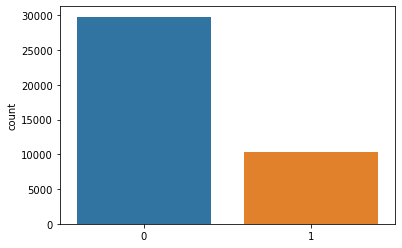

In [39]:
sns.countplot(y_train_and_validation)
plt.show()

In [40]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state = 0,sampling_strategy = 'auto')
X_train_and_validation, y_train_and_validation = rus.fit_sample(X_train_and_validation, y_train_and_validation)

In [42]:
img_pca = PCA(n_components = 0.8)
img_pca.fit(X_train_and_validation,y_train_and_validation)
X_train_and_validation = img_pca.transform(X_train_and_validation)
X_test = img_pca.transform(X_test)

##### Učenje modela i evaluacija

In [44]:
best_model = svm.SVC(kernel = 'rbf', C=best_c, gamma=best_gamma)
best_model.fit(X_train_and_validation,y_train_and_validation)

SVC(C=1, gamma=0.01)

In [45]:
y_pred = best_model.predict(X_test)

In [47]:
score = metrics.accuracy_score(y_test,y_pred)
print("Tačnost modela: {:.2f}" .format(score))

Tačnost modela: 0.83


In [48]:
f1_score = metrics.f1_score(y_test,y_pred)
print('F1 score modela: {:.2f}' .format(f1_score))

F1 score modela: 0.71


In [51]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.83


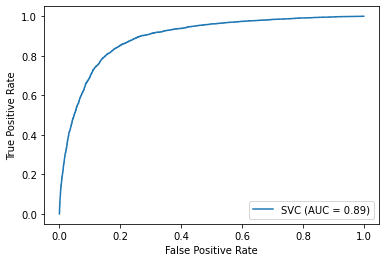

In [53]:
metrics.plot_roc_curve(best_model,X_test,y_test)
plt.show()

In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     14678
           1       0.63      0.82      0.71      5122

    accuracy                           0.83     19800
   macro avg       0.78      0.83      0.80     19800
weighted avg       0.85      0.83      0.84     19800



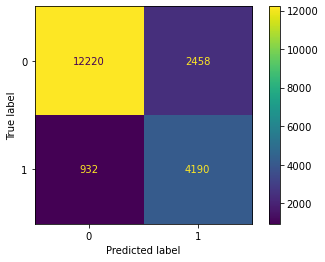

In [50]:
plot_confusion_matrix(best_model,X_test,y_test)
plt.show()

### Čuvanje modela

In [54]:
import pickle

In [55]:
file_name = 'models/svm.model'
with open(file_name,'wb') as file:
    pickle.dump(best_model,file)